In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as Data

dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 文本预处理

In [2]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

In [3]:
word_sequence = " ".join(sentences).split()

In [4]:
word_sequence

['jack',
 'like',
 'dog',
 'jack',
 'like',
 'cat',
 'jack',
 'like',
 'animal',
 'dog',
 'cat',
 'animal',
 'banana',
 'apple',
 'cat',
 'dog',
 'like',
 'dog',
 'fish',
 'milk',
 'like',
 'dog',
 'cat',
 'animal',
 'like',
 'jack',
 'like',
 'apple',
 'apple',
 'like',
 'jack',
 'like',
 'banana',
 'apple',
 'banana',
 'jack',
 'movie',
 'book',
 'music',
 'like',
 'cat',
 'dog',
 'hate',
 'cat',
 'dog',
 'like']

In [5]:
vocab = list(set(word_sequence))

In [6]:
vocab

['cat',
 'book',
 'like',
 'banana',
 'apple',
 'milk',
 'hate',
 'fish',
 'dog',
 'music',
 'movie',
 'animal',
 'jack']

In [7]:
word2idx = {w:i for i, w in enumerate(vocab)}

In [8]:
word2idx

{'cat': 0,
 'book': 1,
 'like': 2,
 'banana': 3,
 'apple': 4,
 'milk': 5,
 'hate': 6,
 'fish': 7,
 'dog': 8,
 'music': 9,
 'movie': 10,
 'animal': 11,
 'jack': 12}

### 相关参数设置

In [9]:
batch_size = 8
embedding_size = 2
C = 2 # window size
voc_size = len(vocab)

### 数据预处理

In [10]:
skip_grams = []
for idx in range(C, len(word_sequence)-C):
    center = word2idx[word_sequence[idx]]
    context_idx = list(range(idx-C, idx)) + list(range(idx+1, idx+C+1))
    context = [word2idx[word_sequence[i]] for i in context_idx]
    for w in context:
        skip_grams.append([center, w])

In [11]:
skip_grams

[[8, 12],
 [8, 2],
 [8, 12],
 [8, 2],
 [12, 2],
 [12, 8],
 [12, 2],
 [12, 0],
 [2, 8],
 [2, 12],
 [2, 0],
 [2, 12],
 [0, 12],
 [0, 2],
 [0, 12],
 [0, 2],
 [12, 2],
 [12, 0],
 [12, 2],
 [12, 11],
 [2, 0],
 [2, 12],
 [2, 11],
 [2, 8],
 [11, 12],
 [11, 2],
 [11, 8],
 [11, 0],
 [8, 2],
 [8, 11],
 [8, 0],
 [8, 11],
 [0, 11],
 [0, 8],
 [0, 11],
 [0, 3],
 [11, 8],
 [11, 0],
 [11, 3],
 [11, 4],
 [3, 0],
 [3, 11],
 [3, 4],
 [3, 0],
 [4, 11],
 [4, 3],
 [4, 0],
 [4, 8],
 [0, 3],
 [0, 4],
 [0, 8],
 [0, 2],
 [8, 4],
 [8, 0],
 [8, 2],
 [8, 8],
 [2, 0],
 [2, 8],
 [2, 8],
 [2, 7],
 [8, 8],
 [8, 2],
 [8, 7],
 [8, 5],
 [7, 2],
 [7, 8],
 [7, 5],
 [7, 2],
 [5, 8],
 [5, 7],
 [5, 2],
 [5, 8],
 [2, 7],
 [2, 5],
 [2, 8],
 [2, 0],
 [8, 5],
 [8, 2],
 [8, 0],
 [8, 11],
 [0, 2],
 [0, 8],
 [0, 11],
 [0, 2],
 [11, 8],
 [11, 0],
 [11, 2],
 [11, 12],
 [2, 0],
 [2, 11],
 [2, 12],
 [2, 2],
 [12, 11],
 [12, 2],
 [12, 2],
 [12, 4],
 [2, 2],
 [2, 12],
 [2, 4],
 [2, 4],
 [4, 12],
 [4, 2],
 [4, 4],
 [4, 2],
 [4, 2],
 [4, 4]

In [12]:
def make_data(skip_grams):
    input_data = []
    output_data = []
    for a, b in skip_grams:
        input_data.append(np.eye(voc_size)[a])
        output_data.append(b)
    return input_data, output_data

In [13]:
input_data, output_data = make_data(skip_grams)
input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)
dataset = Data.TensorDataset(input_data, output_data)
loader = Data.DataLoader(dataset, batch_size, True)

### 构建模型

In [15]:
class Word2vec(nn.Module):
    def __init__(self):
        super(Word2vec, self).__init__()
        
        self.W = nn.Parameter(torch.randn(voc_size, embedding_size).type(dtype))
        self.V = nn.Parameter(torch.randn(embedding_size, voc_size).type(dtype))
        
    def forward(self, X):
        # X : [batch_size, vocab_size] one-hot
        hidden_layer = torch.matmul(X, self.W)  # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        return output_layer

In [17]:
model = Word2vec().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 训练

In [20]:
for epoch in range(2000):
    for i, (batch_x, batch_y) in enumerate(loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        if (epoch+1) % 1000 == 0:
            print(epoch+1, i, loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

1000 0 2.152482748031616
1000 1 1.9865167140960693
1000 2 2.026981830596924
1000 3 1.8475193977355957
1000 4 2.0837037563323975
1000 5 2.20550537109375
1000 6 1.967031717300415
1000 7 1.6942301988601685
1000 8 2.133023262023926
1000 9 1.9756050109863281
1000 10 1.757044792175293
1000 11 2.1352717876434326
1000 12 2.267244577407837
1000 13 2.133307456970215
1000 14 2.0837016105651855
1000 15 1.7351120710372925
1000 16 2.3725967407226562
1000 17 2.1537933349609375
1000 18 2.126396894454956
1000 19 2.625025749206543
1000 20 1.8604875802993774
2000 0 2.4623634815216064
2000 1 2.061760902404785
2000 2 2.212667226791382
2000 3 2.2853450775146484
2000 4 2.0874717235565186
2000 5 1.866732120513916
2000 6 2.035996437072754
2000 7 2.0916199684143066
2000 8 1.8228882551193237
2000 9 1.7618165016174316
2000 10 1.924320101737976
2000 11 1.986958384513855
2000 12 1.8284839391708374
2000 13 2.3623318672180176
2000 14 2.1919727325439453
2000 15 1.9248788356781006
2000 16 1.8745734691619873
2000 17 2.0

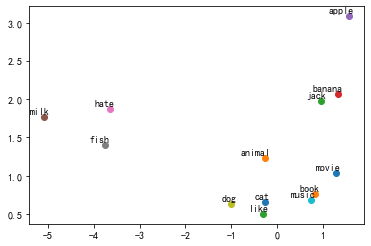

In [21]:
for i, label in enumerate(vocab):
    W, WT = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x,y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()